Этот модуль дает интуитивно понятное введение в очень фундаментальные концепции переобучения и недообучения в машинном обучении.

Модели машинного обучения никогда не могут делать идеальные прогнозы: ошибка теста никогда не равна нулю. Этот провал происходит из -за фундаментального компромисса между гибкостью моделирования и ограниченным размером обучающего набора данных .

Первая презентация определит эти проблемы и охарактеризует, как и почему они возникают.

Затем мы представим методологию количественной оценки этих проблем путем сравнения ошибки поезда с ошибкой теста для различного выбора семейства моделей и параметров модели. Что еще более важно, мы подчеркнем влияние размера обучающей выборки на этот компромисс .

Наконец, мы свяжем переоснащение и недообучение с понятиями статистической дисперсии и систематической ошибки.

адачи в модуле следующие:

понять концепцию переобучения и недообучения;

понимать понятие обобщения;

понимать общую структуру перекрестной проверки, используемую для оценки модели.

### Overfitting and underfitting

Cross-validation framework

Структура перекрестной проверки 

В предыдущих записных книжках мы вводим некоторые понятия, касающиеся оценки прогностических моделей. Хотя этот раздел может быть немного избыточным, мы намерены подробно остановиться на структуре перекрестной проверки.

Прежде чем мы углубимся в это, давайте остановимся на причинах всегда иметь наборы для обучения и тестирования. Давайте сначала рассмотрим ограничение использования набора данных без исключения каких-либо образцов.

Чтобы проиллюстрировать различные концепции, мы будем использовать набор данных о жилье в Калифорнии.

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

В этом наборе данных цель состоит в том, чтобы предсказать медианную стоимость домов в районе Калифорнии. Собранные функции основаны на общей информации о недвижимости и географических данных.

Поэтому задача для решения отличается от той, что показана в предыдущей тетради. Предсказываемая цель является непрерывной переменной, а не дискретной. Эта задача называется регрессией.

Для этого мы будем использовать прогностическую модель, специфичную для регрессии, а не для классификации.

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [4]:
target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

Чтобы упростить будущую визуализацию, давайте преобразуем цены из диапазона 100 (k$) 

в диапазон тысяч долларов (k$).

In [5]:
target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

#### Ошибка обучения и ошибка тестирования 

Чтобы решить эту задачу регрессии, мы будем использовать регрессор дерева решений.

In [8]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)


DecisionTreeRegressor(random_state=0)

In [9]:
from sklearn import set_config
set_config(display='diagram')

In [10]:
regressor

DecisionTreeRegressor(random_state=0)

После обучения регрессора мы хотели бы узнать его потенциальную производительность обобщения после развертывания в рабочей среде. Для этой цели мы используем среднюю абсолютную ошибку, которая дает нам ошибку в исходной единице, т.е. k$.

In [11]:
from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


Мы получаем идеальный прогноз без ошибок. Это слишком оптимистично и почти всегда выявляет методологическую проблему при машинном обучении.

Действительно, мы тренировались и прогнозировали на одном и том же наборе данных. Поскольку наше дерево решений полностью выросло, каждая выборка в наборе данных хранится в конечном узле. Таким образом, наше дерево решений полностью запоминало набор данных, предоставленный во время, fit и поэтому не допускало ошибок при прогнозировании.

Эта рассчитанная выше ошибка называется эмпирической ошибкой или ошибкой обучения .

Мы обучили прогностическую модель, чтобы свести к минимуму ошибку обучения, но наша цель — свести к минимуму ошибку данных, которые не были замечены во время обучения.

Эту ошибку также называют ошибкой обобщения или «истинной» ошибкой тестирования .

Таким образом, самая основная оценка включает в себя:

разделение нашего набора данных на два подмножества: обучающий набор и набор для тестирования;

примерка модели на обучающем наборе;

оценку ошибки обучения на обучающей выборке;

оценка ошибки тестирования на тестовом множестве.

Итак, давайте разделим наш набор данных.

In [12]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

Затем давайте обучим нашу модель.

In [13]:
regressor.fit(data_train, target_train)

DecisionTreeRegressor(random_state=0)

Наконец, мы оцениваем различные типы ошибок. Начнем с вычисления ошибки обучения.

In [14]:
target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


Мы наблюдаем те же явления, что и в предыдущем эксперименте: наша модель запомнила обучающую выборку. Однако теперь мы вычисляем ошибку тестирования.

In [15]:
target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.28 k$


Эта ошибка тестирования на самом деле связана с тем, что мы ожидали бы от нашей модели, если бы она использовалась в производственной среде.

#### Стабильность оценок перекрестной проверки 

При выполнении одного разделения поезд-тест мы не даем никаких указаний относительно надежности оценки нашей прогностической модели: в частности, если набор тестов мал, эта оценка ошибки тестирования будет нестабильной и не будет отражать «истинная частота ошибок», которую мы наблюдали бы с той же моделью на неограниченном количестве тестовых данных.

Например, нам могло повезти, когда мы сделали случайное разделение нашего ограниченного набора данных и случайно выделили некоторые из самых простых для прогнозирования случаев в тестовом наборе: в этом случае оценка ошибки тестирования была бы чрезмерно оптимистичной.

Перекрестная проверка позволяет оценить надежность прогностической модели путем повторения процедуры разделения. Это даст несколько ошибок обучения и тестирования и, таким образом, некоторую оценку изменчивости производительности обобщения модели .

Существуют разные стратегии перекрестной проверки , сейчас мы сосредоточимся на одной, называемой «перетасовка-разделение». На каждой итерации этой стратегии мы:

случайно перетасовать порядок образцов копии полного набора данных;

разделить перетасованный набор данных на поезд и тестовый набор;

обучить новую модель на поезде;

оценить ошибку тестирования на тестовом наборе.

Повторяем эту процедуру n_splitsраз. Имейте в виду, что вычислительная стоимость увеличивается с n_splits.

![](https://inria.github.io/scikit-learn-mooc/_images/shufflesplit_diagram.png)

На этом рисунке показан частный случай стратегии перекрестной проверки в случайном порядкеn_splits=5 с использованием . Для каждого разделения перекрестной проверки процедура обучает модель на всех красных образцах и оценивает оценку модели на синих образцах.

В этом случае мы установим n_splits=40, что означает, что всего мы обучим 40 моделей, и все они будут отброшены: мы просто записываем их эффективность обобщения на каждом варианте тестового набора.

Чтобы оценить производительность обобщения нашего регрессора, мы можем использовать sklearn.model_selection.cross_validate с sklearn.model_selection.ShuffleSplit объектом:

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error")

Результаты cv_resultsсохраняются в словаре Python. Мы преобразуем его в фрейм данных pandas, чтобы упростить визуализацию и манипулирование.

In [18]:
import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head(10)

,fit_time,score_time,test_score
0,0.112997,0.000000,-46.909797
1,0.110834,0.000000,-46.421170
2,0.112016,0.000000,-47.411089
3,0.111001,0.002102,-44.319824
4,0.107722,0.001999,-47.607875
5,0.108330,0.001993,-45.901300
6,0.108706,0.001966,-46.572767
7,0.104813,0.005600,-46.194585
8,0.106206,0.003693,-45.590236
9,0.109070,0.002961,-45.727998


Оценка — это показатель, для которого более высокие значения означают лучшие результаты. Наоборот, ошибка — это показатель, для которого более низкие значения означают лучшие результаты.

Параметр всегда scoring ожидает cross_validate функцию, которая является оценкой.

Для простоты все метрики ошибок в scikit-learn, такие как mean_absolute_error, можно преобразовать в оценку, которая будет использоваться в cross_validate. 

Для этого вам нужно передать строку метрики ошибок с дополнительной neg_строкой впереди параметру scoring; например scoring="neg_mean_absolute_error".

В этом случае будет вычислено отрицательное значение средней абсолютной ошибки, что будет эквивалентно баллу.

Давайте вернем отрицание, чтобы получить реальную ошибку:

In [19]:
cv_results["test_error"] = -cv_results["test_score"]

Давайте проверим результаты перекрестной проверки.

In [20]:
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.112997,0.000000,-46.909797,46.909797
1,0.110834,0.000000,-46.421170,46.421170
2,0.112016,0.000000,-47.411089,47.411089
3,0.111001,0.002102,-44.319824,44.319824
4,0.107722,0.001999,-47.607875,47.607875
5,0.108330,0.001993,-45.901300,45.901300
6,0.108706,0.001966,-46.572767,46.572767
7,0.104813,0.005600,-46.194585,46.194585
8,0.106206,0.003693,-45.590236,45.590236
9,0.109070,0.002961,-45.727998,45.727998


Мы получаем информацию о времени для подгонки и прогнозирования на каждой итерации перекрестной проверки. Также мы получаем тестовый балл, который соответствует ошибке тестирования на каждом из сплитов.

In [21]:
len(cv_results)

40

Мы получаем 40 записей в результирующем фрейме данных, потому что мы выполнили 40 разбиений. Следовательно, мы можем показать распределение ошибок тестирования и, таким образом, оценить его изменчивость.

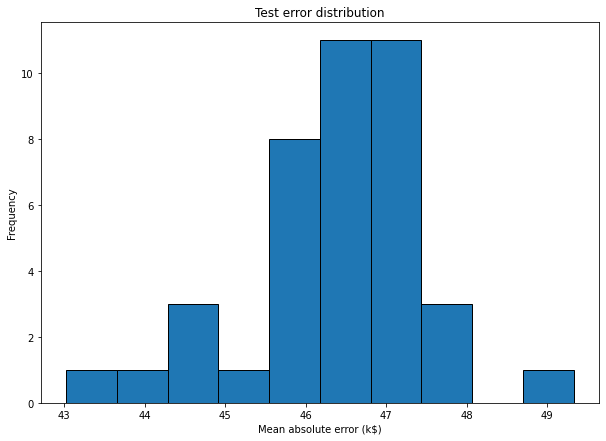

In [28]:
import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black", figsize =(10, 7))
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")



Мы видим, что ошибка тестирования сгруппирована вокруг 47 тысяч долларов и колеблется от 43 тысяч долларов до 50 тысяч долларов.

In [29]:
print(f"The mean cross-validated testing error is: "
      f"{cv_results['test_error'].mean():.2f} k$")

The mean cross-validated testing error is: 46.36 k$


In [30]:
print(f"The standard deviation of the testing error is: "
      f"{cv_results['test_error'].std():.2f} k$")

The standard deviation of the testing error is: 1.17 k$


Обратите внимание, что стандартное отклонение намного меньше среднего: мы могли бы резюмировать, что наша перекрестная оценка ошибки тестирования составляет 46,36 ± 1,17 тыс. $.

Если бы мы обучили одну модель на полном наборе данных (без перекрестной проверки), а затем получили доступ к неограниченному количеству тестовых данных, мы бы ожидали, что ее истинная ошибка тестирования будет близка к этой области.

Хотя эта информация интересна сама по себе, ее следует сопоставить с масштабом естественной изменчивости вектора targetв нашем наборе данных.

Построим распределение целевой переменной:

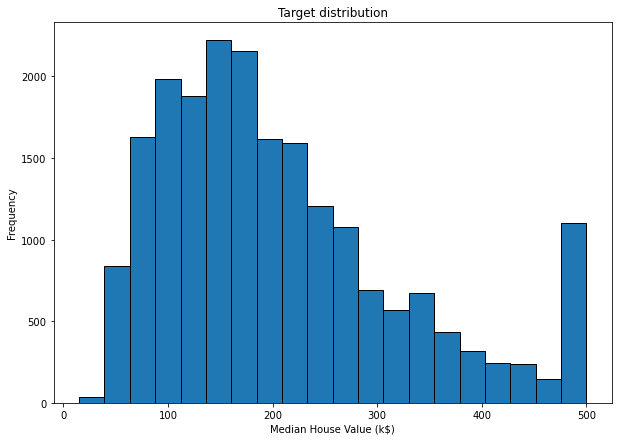

In [32]:
target.plot.hist(bins=20, edgecolor="black", figsize =(10, 7))
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

In [33]:
print(f"The standard deviation of the target is: {target.std():.2f} k$")

The standard deviation of the target is: 115.40 k$


Целевая переменная колеблется от почти 0 тысяч долларов до 500 тысяч долларов со стандартным отклонением около 115 тысяч долларов.

Мы замечаем, что средняя оценка ошибки тестирования, полученная перекрестной проверкой, немного меньше естественного масштаба вариации целевой переменной. Кроме того, стандартное отклонение оценки перекрестной проверки ошибки тестирования еще меньше.

Это хорошее начало, но его недостаточно, чтобы решить, достаточно ли хороша производительность обобщения, чтобы сделать наш прогноз полезным на практике.

Напомним, что наша модель в среднем дает ошибку около 47 тыс. долл. США. Имея эту информацию и глядя на целевое распределение, такая ошибка может быть приемлемой при прогнозировании домов с 500 тысячами долларов. Однако это было бы проблемой с домом стоимостью 50 тысяч долларов. Таким образом, это указывает на то, что наша метрика (средняя абсолютная ошибка) не идеальна.

Вместо этого мы могли бы выбрать показатель относительно целевого значения для прогнозирования: гораздо лучшим выбором была бы средняя абсолютная процентная ошибка.

Но во всех случаях ошибка в 47 тысяч долларов может оказаться слишком большой для автоматического использования нашей модели для маркировки стоимости домов без экспертного контроля.

#### Подробнее о cross_validate

Во время перекрестной проверки многие модели обучаются и оцениваются. Действительно, количество элементов в каждом массиве вывода cross_validateявляется результатом одной из этих fit/ scoreпроцедур. Чтобы сделать это явным, можно получить эти подогнанные модели для каждого из расщеплений/складок, передав параметр return_estimator=Trueв cross_validate.

In [34]:
cv_results = cross_validate(regressor, data, target, return_estimator=True)
cv_results

{'fit_time': array([0.13367248, 0.13264561, 0.12363744, 0.12354398, 0.1199131 ]),
 'score_time': array([0.00199413, 0.00199533, 0.00199533, 0.00199485, 0.00199509]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])}

In [35]:
cv_results["estimator"]

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

Пять регрессоров деревьев решений соответствуют пяти подобранным деревьям решений на разных складках. Доступ к этим регрессорам удобен, 

потому что он позволяет проверить внутренние подогнанные параметры этих регрессоров.

В случае, когда вас интересует только результат теста, scikit-learn предоставляет cross_val_scoreфункцию. 

Это идентично вызову cross_validateфункции и выбору test_scoreединственного (как мы часто делали в предыдущих блокнотах).

In [36]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])

#### Резюме 
В этом блокноте мы увидели:

необходимость разделения данных на набор train  и test;

значение ошибок обучения и тестирования;

общая структура перекрестной проверки с возможностью изучения изменений производительности обобщения.

## Overfit-general-underfit

In [37]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

#### Переобучение против недообучения 
Чтобы лучше понять эффективность обобщения нашей модели и, возможно, найти способы ее улучшения, мы сравним ошибку тестирования с ошибкой обучения. Таким образом, нам нужно вычислить ошибку на обучающей выборке, что возможно с помощью cross_validate функции.

In [38]:
import pandas as pd
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)
cv_results = cross_validate(regressor, data, target,
                            cv=cv, scoring="neg_mean_absolute_error",
                            return_train_score=True, n_jobs=2)
cv_results = pd.DataFrame(cv_results)

В перекрестной проверке использовалась отрицательная средняя абсолютная ошибка. Преобразуем отрицательную среднюю абсолютную ошибку в положительную среднюю абсолютную ошибку.

In [39]:
scores = pd.DataFrame()
scores[["train error", "test error"]] = -cv_results[
    ["train_score", "test_score"]]

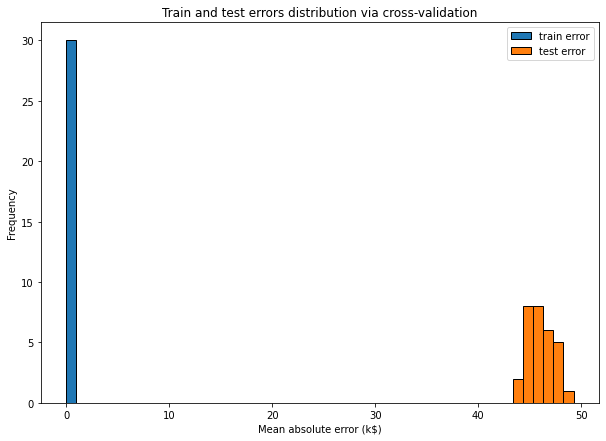

In [41]:
import matplotlib.pyplot as plt

scores.plot.hist(bins=50, edgecolor="black", figsize =(10, 7))
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Train and test errors distribution via cross-validation")

Построив график распределения ошибок обучения и тестирования, мы получаем информацию о том, является ли наша модель подгонкой, подгонкой (или и тем, и другим одновременно).

Здесь мы наблюдаем небольшую ошибку обучения (на самом деле нулевую), что означает, что модель не является недостаточно подходящей : она достаточно гибкая, чтобы фиксировать любые изменения, присутствующие в обучающем наборе.

Однако значительно большая ошибка тестирования говорит нам о том, что модель переобучается : модель запомнила множество вариантов обучающего набора, которые можно было бы считать «зашумленными», поскольку они не обобщаются, чтобы помочь нам сделать хороший прогноз на тестовом наборе.

#### Кривая проверки 
Некоторые гиперпараметры модели обычно являются ключом к переходу от модели, которая не подходит, к модели, которая подходит лучше, мы надеемся, пройдя через область, где мы сможем получить хороший баланс между ними. Мы можем получить знания, построив кривую, называемую кривой проверки. Эта кривая также может быть применена к приведенному выше эксперименту и меняет значение гиперпараметра.

Для дерева решений max_depthпараметр используется для управления компромиссом между подгонкой и переподгонкой.

In [42]:
%%time
from sklearn.model_selection import validation_curve

max_depth = [1, 5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(
    regressor, data, target, param_name="max_depth", param_range=max_depth,
    cv=cv, scoring="neg_mean_absolute_error", n_jobs=2)
train_errors, test_errors = -train_scores, -test_scores

Wall time: 7.87 s


Теперь, когда мы собрали результаты, мы покажем кривую проверки, нанеся на график ошибки обучения и тестирования (а также их отклонения).

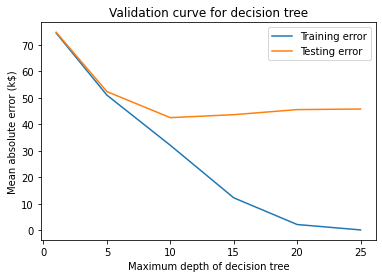

In [46]:
plt.plot(max_depth, train_errors.mean(axis=1), label="Training error")
plt.plot(max_depth, test_errors.mean(axis=1), label="Testing error")
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

Кривую валидации можно разделить на три области:

Для дерево решений не подходит. Ошибка обучения и, следовательно, ошибка тестирования высоки. Модель слишком ограничена и не может отразить большую часть изменчивости целевой переменной.max_depth < 10

Область вокруг соответствует параметру, для которого дерево решений обобщает лучше всего. Он достаточно гибок, чтобы захватить часть изменчивости цели, которая обобщает, не запоминая при этом весь шум в цели.max_depth = 10

Для дерево решений переобучается. Ошибка обучения становится очень малой, а ошибка тестирования увеличивается. В этой области модели создают решения специально для зашумленных выборок, что наносит ущерб его способности обобщать тестовые данные.max_depth > 10

Обратите внимание, что для модель немного переобучается, так как существует разрыв между ошибкой обучения и ошибкой тестирования. В то же время он также потенциально может немного недооценивать, потому что ошибка обучения все еще далека от нуля (более 30 тысяч долларов), а это означает, что модель все еще может быть слишком ограничена для моделирования интересных частей данных. Однако погрешность тестирования минимальна, а это главное. Это лучший компромисс, которого мы могли бы достичь, просто настроив этот параметр.max_depth = 10

Имейте в виду, что просмотр средних ошибок весьма ограничен. Мы также должны посмотреть на стандартное отклонение, чтобы оценить дисперсию оценки. Мы можем повторить тот же график, что и раньше, но на этот раз мы добавим некоторую информацию, чтобы показать стандартное отклонение ошибок.

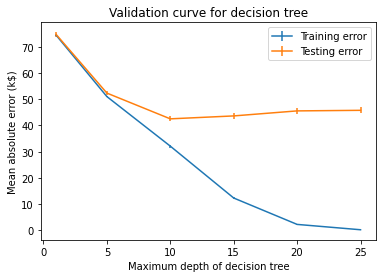

In [47]:
plt.errorbar(max_depth, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label='Training error')
plt.errorbar(max_depth, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label='Testing error')
plt.legend()

plt.xlabel("Maximum depth of decision tree")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Validation curve for decision tree")

Нам повезло, что дисперсия ошибок была мала по сравнению с их соответствующими значениями, и поэтому сделанные выше выводы вполне ясны. Это не всегда так.

Резюме: 
В этом блокноте мы увидели:

как определить, является ли модель обобщающей, переоснащенной или неподходящей;

как проверить влияние гиперпараметра на компромисс между недообучением/переоснащением.

### Влияние размера выборки на перекрестную проверку

In [48]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

#### Кривая обучения 

Чтобы понять влияние количества выборок, доступных для обучения, на эффективность обобщения прогностической модели, можно синтетически уменьшить количество выборок, используемых для обучения прогностической модели, и проверить ошибки обучения и тестирования.

Поэтому мы можем варьировать количество образцов в обучающей выборке и повторять эксперимент. Оценки обучения и тестирования можно построить аналогично кривой проверки, но вместо изменения гиперпараметра мы изменяем количество обучающих выборок. Эта кривая называется кривой обучения .

Он дает информацию о пользе добавления новых обучающих выборок для улучшения производительности обобщения модели.

Давайте вычислим кривую обучения для дерева решений и изменим долю обучающего набора от 10% до 100%.

In [54]:
import numpy as np
train_sizes = np.linspace(0.1, 1.0, num=5, endpoint=True)
train_sizes

array([0.1  , 0.325, 0.55 , 0.775, 1.   ])

Мы будем использовать ShuffleSplitперекрестную проверку для оценки нашей прогностической модели.

In [56]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=30, test_size=0.2)

Теперь все готово для проведения эксперимента.

from sklearn.model_selection import learning_curve

results = learning_curve(
    regressor, data, target, train_sizes=train_sizes, cv=cv,
    scoring="neg_mean_absolute_error", n_jobs=2)
train_size, train_scores, test_scores = results[:3]
# Convert the scores into errors
train_errors, test_errors = -train_scores, -test_scores

Теперь мы можем построить кривую.

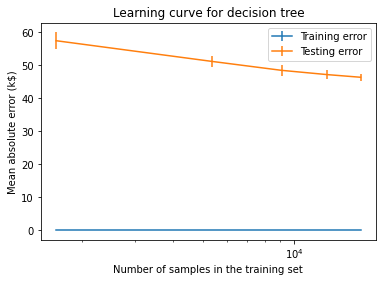

In [59]:
import matplotlib.pyplot as plt

plt.errorbar(train_size, train_errors.mean(axis=1),
             yerr=train_errors.std(axis=1), label="Training error")
plt.errorbar(train_size, test_errors.mean(axis=1),
             yerr=test_errors.std(axis=1), label="Testing error")
plt.legend()

plt.xscale("log")
plt.xlabel("Number of samples in the training set")
plt.ylabel("Mean absolute error (k$)")
_ = plt.title("Learning curve for decision tree")

Резюме 
В тетради мы узнали:

влияние количества выборок в наборе данных, особенно на изменчивость ошибок, сообщаемых при выполнении перекрестной проверки;

о кривой обучения, которая представляет собой визуальное представление способности модели улучшаться за счет добавления новых образцов.

## Решение упражнения М2.01 
Цель этого упражнения состоит в том, чтобы провести следующие эксперименты:

обучать и тестировать машинный классификатор опорных векторов посредством перекрестной проверки;

изучить влияние гамма-параметра этого классификатора с помощью проверочной кривой;

используйте кривую обучения, чтобы определить полезность добавления новых выборок в набор данных при построении классификатора.

Чтобы провести эти эксперименты, мы сначала загрузим набор данных переливания крови.

In [60]:
import pandas as pd

blood_transfusion = pd.read_csv("data/blood_transfusion.csv")
data = blood_transfusion.drop(columns="Class")
target = blood_transfusion["Class"]

Мы будем использовать классификатор машины опорных векторов (SVM). В своей самой простой форме классификатор SVM представляет собой линейный классификатор, ведущий себя аналогично логистической регрессии. Действительно, оптимизация, используемая для нахождения оптимальных весов линейной модели, отличается, но нам не нужно знать эти детали для упражнения.

Кроме того, этот классификатор может стать более гибким/выразительным за счет использования так называемого ядра, которое делает модель нелинейной. Опять же, для выполнения этого упражнения не требуется никаких математических знаний.

Мы будем использовать ядро ​​RBF, где параметр gammaпозволяет настроить гибкость модели.

Сначала давайте создадим конвейер прогнозирования, состоящий из:

a sklearn.preprocessing.StandardScaler с параметром по умолчанию;

a, sklearn.svm.SVC где параметр kernelможет быть установлен в "rbf". Обратите внимание, что это значение по умолчанию.

In [61]:
# solution
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

model = make_pipeline(StandardScaler(), SVC())

Оцените эффективность обобщения вашей модели путем перекрестной проверки со ShuffleSplitсхемой. Таким образом, вы можете использовать sklearn.model_selection.cross_validate и передать sklearn.model_selection.ShuffleSplit в cvпараметр. Исправьте только random_state=0в ShuffleSplit и оставьте остальные параметры по умолчанию.

In [62]:
# solution
from sklearn.model_selection import cross_validate, ShuffleSplit

cv = ShuffleSplit(random_state=0)
cv_results = cross_validate(model, data, target, cv=cv, n_jobs=2)
cv_results = pd.DataFrame(cv_results)
cv_results

,fit_time,score_time,test_score
0,0.016926,0.003991,0.680000
1,0.015929,0.003989,0.746667
2,0.016954,0.003989,0.786667
3,0.016954,0.003991,0.800000
4,0.016955,0.002993,0.746667
5,0.015957,0.002992,0.786667
6,0.014960,0.002992,0.800000
7,0.014960,0.003989,0.826667
8,0.014961,0.003024,0.746667
9,0.013963,0.004017,0.733333


In [63]:
print(
    f"Accuracy score of our model:\n"
    f"{cv_results['test_score'].mean():.3f} ± "
    f"{cv_results['test_score'].std():.3f}"
)

Accuracy score of our model:
0.765 ± 0.043


Как упоминалось ранее, этот параметр gammaявляется одним из параметров, контролирующих подгонку/подгонку в машине опорных векторов с ядром RBF.

Оцените влияние параметра gammaс помощью sklearn.model_selection.validation_curve функции. Вы можете оставить значение по умолчанию scoring=None, которое эквивалентно scoring="accuracy"задачам классификации. Вы можете варьировать gammaмежду 10e-3и 10e2путем создания образцов в логарифмическом масштабе с помощью .np.logspace(-3, 2, num=30)

Поскольку мы манипулируем, Pipeline имя параметра будет установлено svc__gamma вместо только gamma. Вы можете получить имя параметра, используя model.get_params().keys(). Мы более подробно рассмотрим доступ и настройку гиперпараметра в следующем разделе.

In [64]:
# solution
import numpy as np
from sklearn.model_selection import validation_curve

gammas = np.logspace(-3, 2, num=30)
param_name = "svc__gamma"
train_scores, test_scores = validation_curve(
    model, data, target, param_name=param_name, param_range=gammas, cv=cv,
    n_jobs=2)

Постройте кривую проверки для результатов поезда и теста.

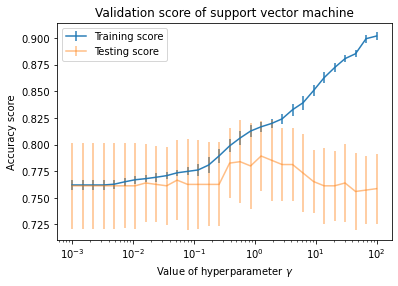

In [65]:
# solution
import matplotlib.pyplot as plt

plt.errorbar(
    gammas,
    train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    alpha=0.95,
    label="Training score",
)
plt.errorbar(
    gammas,
    test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1),
    alpha=0.5,
    label="Testing score",
)
plt.legend()

plt.xscale("log")
plt.xlabel(r"Value of hyperparameter $\gamma$")
plt.ylabel("Accuracy score")
_ = plt.title("Validation score of support vector machine")

Глядя на кривую, мы можем четко определить режим переобучения классификатора SVC, когда . Наилучшие настройки находятся примерно в то время как для , не очень ясно, подходит ли классификатор недостаточно, но результат тестирования хуже, чем для .gamma > 1gamma = 1gamma < 1gamma = 1

Теперь вы можете выполнить анализ, чтобы проверить, может ли добавление новых выборок в набор данных помочь нашей модели лучше обобщать. Вычислите кривую обучения (используя sklearn.model_selection.learning_curve) путем вычисления результатов обучения и тестов для различного размера набора обучающих данных. Постройте поезд и результаты тестов в зависимости от количества выборок.

In [66]:
# solution
from sklearn.model_selection import learning_curve

train_sizes = np.linspace(0.1, 1, num=10)
results = learning_curve(
    model, data, target, train_sizes=train_sizes, cv=cv, n_jobs=2)
train_size, train_scores, test_scores = results[:3]

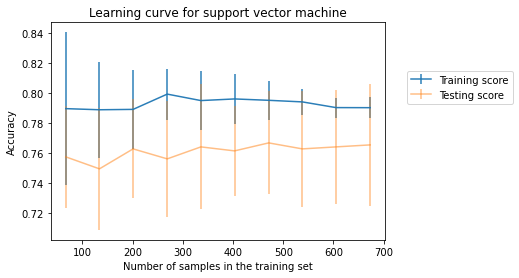

In [67]:
plt.errorbar(
    train_size,
    train_scores.mean(axis=1),
    yerr=train_scores.std(axis=1),
    alpha=0.95,
    label="Training score",
)
plt.errorbar(
    train_size,
    test_scores.mean(axis=1),
    yerr=test_scores.std(axis=1),
    alpha=0.5,
    label="Testing score",
)
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")

plt.xlabel("Number of samples in the training set")
plt.ylabel("Accuracy")
_ = plt.title("Learning curve for support vector machine")

Мы наблюдаем, что добавление новых образцов в набор обучающих данных, по-видимому, не улучшает результаты обучения и тестирования. В частности, точность результатов тестирования колеблется в районе 76%. Действительно, ~76% образцов относятся к классу . Обратите внимание, что классификатор, который всегда предсказывает класс, достигнет точности 76% без использования какой-либо информации из самих данных. Это может означать, что наш небольшой конвейер не может использовать входные функции для улучшения этого упрощенного базового уровня, и увеличение размера обучающей выборки также не помогает."not donated""not donated"

Возможно, входные признаки принципиально малоинформативны и задачу классификации принципиально невозможно решить с высокой точностью. Но также может случиться так, что наш выбор использования значения гиперпараметра по умолчанию для SVCкласса был плохой идеей или что выбор SVCкласса сам по себе неоптимален.

Позже в этом МООК мы увидим, как лучше настраивать гиперпараметры модели, и узнаем, как более систематически сравнивать прогностическую эффективность различных классов моделей.

#### Главный вывод 
Подведение итогов 
Переобучение вызвано ограниченным размером обучающей выборки , шумом в данных и высокой гибкостью распространенных моделей машинного обучения.

Недообучение происходит, когда изученные функции прогнозирования страдают от систематических ошибок . Это может быть вызвано выбором семейства моделей и параметров, что приводит к недостаточной гибкости для захвата повторяемой структуры реального процесса генерации данных.

Для фиксированного обучающего набора цель состоит в том, чтобы свести к минимуму ошибку теста путем настройки семейства моделей и его параметров, чтобы найти наилучший компромисс между переоснащением и недообучением .

При данном выборе семейства моделей и параметров увеличение размера обучающей выборки уменьшит переоснащение, но также может привести к увеличению недообучения.

Ошибка теста модели, которая не является ни переоснащением, ни недообучением, все еще может быть высокой, если вариации целевой переменной не могут быть полностью определены входными признаками. Эта неустранимая ошибка вызвана тем, что мы иногда называем шумом этикетки. На практике это часто происходит, когда мы не имеем доступа к важным функциям по той или иной причине.